[View in Colaboratory](https://colab.research.google.com/github/rafaelszp/dlnd_face_generation/blob/master/dlnd_face_generation.ipynb)

# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#!git clone https://github.com/rafaelszp/dlnd_face_generation.git
#!cp dlnd_face_generation/*.py .
#!pip install -U matplotlib==2.0.2
#!pip install tqdm

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

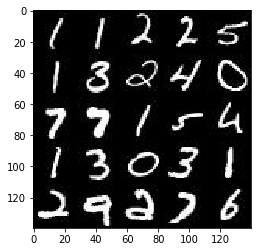

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

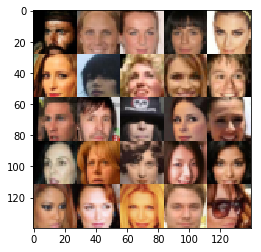

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    x = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels),name='input_real')
    z = tf.placeholder(tf.float32, shape=(None, z_dim),name='noise')
    l = tf.placeholder(tf.float32,name='learning_rate')

    return x, z, l



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

In [7]:

leakyRelu = lambda x,alpha=0.2: tf.maximum(x*alpha,x)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [244]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    #kernel_init = tf.random_normal_initializer(stddev=0.02)
    kernel_init = tf.contrib.layers.xavier_initializer_conv2d()
    
    def conv(images, n_filters, kernel_size=4, strides=2, kernel_initializer=kernel_init, padding='same',is_first=False):
      x = tf.layers.conv2d(images, n_filters, kernel_size, strides, kernel_initializer=kernel_initializer, padding=padding)
      if(not is_first):
        x = tf.layers.batch_normalization(x, training=True)
      x = leakyRelu(x)
      if(not is_first):
          x = tf.nn.dropout(x,keep_prob=0.9)

      return x
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input is 28x28x3
        x = conv(images,64,is_first=True)
        # 14x14x64        
        x = conv(x,128)
        # 7x7x128
        x = conv(x,256)
        # 4x4x256
        
        
        x = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [245]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    #kernel_init = tf.random_normal_initializer(stddev=0.02)
    kernel_init = tf.contrib.layers.xavier_initializer_conv2d()
    
    def deconv(inputs, n_filters, kernel_size=4, strides=2, kernel_initializer=kernel_init, padding='same',is_last=False):
      x = tf.layers.conv2d_transpose(inputs, n_filters, kernel_size, strides=strides, kernel_initializer=kernel_initializer, padding=padding)
      if(not is_last):
        x = tf.layers.batch_normalization(x, training=is_train)
        x = leakyRelu(x)
        x = tf.nn.dropout(x,keep_prob=0.9)        

      return x
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        x = tf.layers.dense(z, 7*7*256)
        x = tf.reshape(x, (-1, 7, 7, 256))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = leakyRelu(x)        
        
        # 7x7x256
        x = deconv(x,128)
        # 14x14x128
        x = deconv(x,64)
        # 28x28x64
        
        
        
        logits = deconv(x,n_filters=out_channel_dim,kernel_size=3,strides=1,is_last=True)
        # 28x28x3
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [277]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
            
    gmodel = generator(input_z,out_channel_dim,is_train=True)
    dmodel, dmodel_logits = discriminator(input_real,reuse=False) 
    gxdmodel, gxdmodel_logits = discriminator(gmodel,reuse=True)
    
    real_labels = tf.ones_like(dmodel) * np.random.uniform(low=0.7,high=1.2,size=1)
    fake_labels = tf.zeros_like(gxdmodel) +  np.random.uniform(low=0.0,high=0.2,size=1)
        
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dmodel_logits,labels=real_labels))
    gxdloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gxdmodel_logits,labels=fake_labels))
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gxdmodel_logits,labels=tf.ones_like(gxdmodel)))
    
    
    
    dloss = dloss + gxdloss 
    
    
    return dloss, gloss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [278]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [g for g in t_vars if g.name.startswith('generator')]
    d_vars = [d for d in t_vars if d.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
      d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(d_loss,var_list=d_vars)
      g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(g_loss,var_list=g_vars)     
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [279]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

In [280]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(x.max() - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [281]:
import time

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    images, noisez, lr = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    dloss,gloss = model_loss(images,noisez,data_shape[3])
    d_train_opt,g_train_opt = model_opt(dloss,gloss,learning_rate,beta1)
    iterations = 0
    
    start_time = time.time()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):

                batch_images = scale(batch_images*2.0)
                iterations +=1
                batch_noisez = np.random.uniform(-1,1,size=(batch_size,z_dim))
                dict_d = {
                  images: batch_images,
                  noisez: batch_noisez
                }
                dict_g = {
                    noisez: batch_noisez,
                    images: batch_images,
                }
                _ = sess.run(d_train_opt,feed_dict=dict_d)
                _ = sess.run(g_train_opt,feed_dict=dict_g)
                #calculating loss for the blablablablablalbla
                if(iterations % 10==0):
                  train_loss_d = dloss.eval({images:batch_images,noisez:batch_noisez})
                  train_loss_g = gloss.eval({noisez: batch_noisez})
                  print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                  
                if iterations % 100 == 0 or iterations*batch_size % 120000==0:
                    print("iteration",iterations)
                    show_generator_output(sess, 25, noisez, data_shape[3], data_image_mode)
        secs_duration = (time.time() - start_time)
        mins_duration = secs_duration/60
        
        print('Training done seconds: {}. Time in minutes: {}. Iterations: {}'.format(secs_duration,mins_duration,iterations))
                
      

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Starting...
Epoch 1/2... Discriminator Loss: 1.8914... Generator Loss: 4.9721
Epoch 1/2... Discriminator Loss: 2.4407... Generator Loss: 0.2558
Epoch 1/2... Discriminator Loss: 1.8323... Generator Loss: 0.4287
Epoch 1/2... Discriminator Loss: 1.9288... Generator Loss: 0.3842
Epoch 1/2... Discriminator Loss: 1.6356... Generator Loss: 0.4986
Epoch 1/2... Discriminator Loss: 1.7780... Generator Loss: 1.1904
Epoch 1/2... Discriminator Loss: 1.6319... Generator Loss: 0.5302
Epoch 1/2... Discriminator Loss: 1.6001... Generator Loss: 0.5448
Epoch 1/2... Discriminator Loss: 1.6604... Generator Loss: 0.5222
Epoch 1/2... Discriminator Loss: 1.5796... Generator Loss: 0.6364
iteration 100


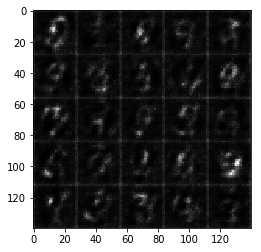

Epoch 1/2... Discriminator Loss: 1.5341... Generator Loss: 0.5976
Epoch 1/2... Discriminator Loss: 1.4295... Generator Loss: 0.8181
Epoch 1/2... Discriminator Loss: 1.3807... Generator Loss: 0.6370
Epoch 1/2... Discriminator Loss: 1.4179... Generator Loss: 0.7445
Epoch 1/2... Discriminator Loss: 1.3127... Generator Loss: 0.8567
Epoch 1/2... Discriminator Loss: 1.2724... Generator Loss: 1.3141
Epoch 1/2... Discriminator Loss: 1.6333... Generator Loss: 0.5618
Epoch 1/2... Discriminator Loss: 2.0177... Generator Loss: 0.3839
Epoch 1/2... Discriminator Loss: 1.1992... Generator Loss: 0.9446
Epoch 1/2... Discriminator Loss: 1.0829... Generator Loss: 1.5176
iteration 200


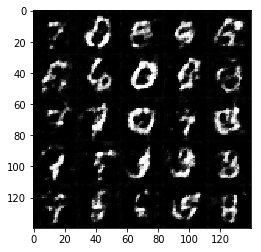

Epoch 1/2... Discriminator Loss: 1.3318... Generator Loss: 0.6457
Epoch 1/2... Discriminator Loss: 1.3231... Generator Loss: 0.7410
Epoch 1/2... Discriminator Loss: 2.0892... Generator Loss: 0.3092
Epoch 1/2... Discriminator Loss: 1.3027... Generator Loss: 1.6603
Epoch 1/2... Discriminator Loss: 1.2794... Generator Loss: 1.2036
Epoch 1/2... Discriminator Loss: 1.2040... Generator Loss: 1.0218
Epoch 1/2... Discriminator Loss: 1.2884... Generator Loss: 1.3396
Epoch 1/2... Discriminator Loss: 1.7030... Generator Loss: 0.4518
Epoch 1/2... Discriminator Loss: 1.2615... Generator Loss: 1.1084
Epoch 1/2... Discriminator Loss: 1.7581... Generator Loss: 2.2991
iteration 300


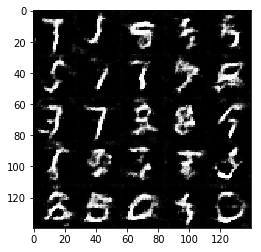

Epoch 1/2... Discriminator Loss: 1.3298... Generator Loss: 0.7010
Epoch 1/2... Discriminator Loss: 1.4347... Generator Loss: 0.6301
Epoch 1/2... Discriminator Loss: 1.5007... Generator Loss: 0.6159
Epoch 1/2... Discriminator Loss: 1.3911... Generator Loss: 0.6646
Epoch 1/2... Discriminator Loss: 1.3067... Generator Loss: 1.4759
Epoch 1/2... Discriminator Loss: 1.5073... Generator Loss: 0.5378
Epoch 1/2... Discriminator Loss: 1.2837... Generator Loss: 1.1199
Epoch 1/2... Discriminator Loss: 1.8062... Generator Loss: 0.4330
Epoch 1/2... Discriminator Loss: 1.3136... Generator Loss: 0.8699
Epoch 1/2... Discriminator Loss: 1.1868... Generator Loss: 1.2562
iteration 400


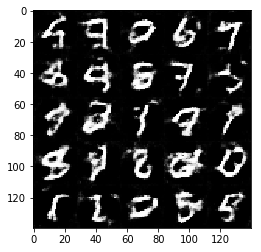

Epoch 1/2... Discriminator Loss: 1.3789... Generator Loss: 0.6484
Epoch 1/2... Discriminator Loss: 1.3991... Generator Loss: 0.6990
Epoch 1/2... Discriminator Loss: 1.2793... Generator Loss: 1.2872
Epoch 1/2... Discriminator Loss: 1.3747... Generator Loss: 1.3526
Epoch 1/2... Discriminator Loss: 1.4974... Generator Loss: 0.5608
Epoch 1/2... Discriminator Loss: 1.4258... Generator Loss: 0.6824
Epoch 1/2... Discriminator Loss: 1.3719... Generator Loss: 0.7468
Epoch 1/2... Discriminator Loss: 1.3002... Generator Loss: 0.8433
Epoch 1/2... Discriminator Loss: 1.3089... Generator Loss: 0.8490
Epoch 1/2... Discriminator Loss: 1.5172... Generator Loss: 0.5024
iteration 500


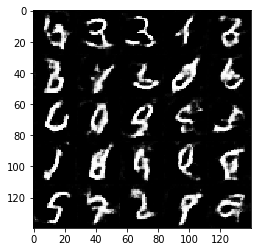

Epoch 1/2... Discriminator Loss: 1.3424... Generator Loss: 0.6956
Epoch 1/2... Discriminator Loss: 1.2301... Generator Loss: 1.0535
Epoch 1/2... Discriminator Loss: 1.3551... Generator Loss: 0.6441
Epoch 1/2... Discriminator Loss: 1.6510... Generator Loss: 2.2853
Epoch 1/2... Discriminator Loss: 1.6181... Generator Loss: 0.5161
Epoch 1/2... Discriminator Loss: 1.3078... Generator Loss: 1.6940
Epoch 1/2... Discriminator Loss: 1.3558... Generator Loss: 0.7391
Epoch 1/2... Discriminator Loss: 1.5188... Generator Loss: 0.5857
Epoch 1/2... Discriminator Loss: 1.3807... Generator Loss: 0.6656
Epoch 1/2... Discriminator Loss: 1.1377... Generator Loss: 1.2377
iteration 600


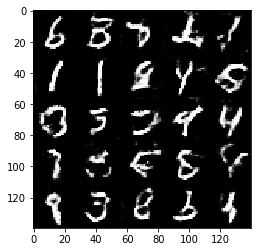

Epoch 1/2... Discriminator Loss: 1.2550... Generator Loss: 0.9137
Epoch 1/2... Discriminator Loss: 1.2508... Generator Loss: 0.8942
Epoch 1/2... Discriminator Loss: 1.4201... Generator Loss: 0.6575
Epoch 1/2... Discriminator Loss: 1.2746... Generator Loss: 1.4784
Epoch 1/2... Discriminator Loss: 1.1677... Generator Loss: 1.0654
Epoch 1/2... Discriminator Loss: 1.4785... Generator Loss: 0.5623
Epoch 1/2... Discriminator Loss: 1.5537... Generator Loss: 0.5610
Epoch 1/2... Discriminator Loss: 1.2857... Generator Loss: 1.2449
Epoch 1/2... Discriminator Loss: 1.3823... Generator Loss: 0.7419
Epoch 1/2... Discriminator Loss: 1.8124... Generator Loss: 0.4320
iteration 700


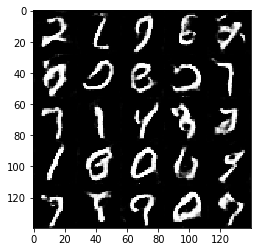

Epoch 1/2... Discriminator Loss: 1.1922... Generator Loss: 1.0912
Epoch 1/2... Discriminator Loss: 1.3873... Generator Loss: 0.7015
Epoch 1/2... Discriminator Loss: 1.1180... Generator Loss: 1.4362
Epoch 1/2... Discriminator Loss: 1.7071... Generator Loss: 0.4387
Epoch 1/2... Discriminator Loss: 1.3033... Generator Loss: 0.8826
Epoch 1/2... Discriminator Loss: 1.3341... Generator Loss: 1.9197
Epoch 1/2... Discriminator Loss: 1.3700... Generator Loss: 1.5734
Epoch 1/2... Discriminator Loss: 1.2800... Generator Loss: 1.3708
Epoch 1/2... Discriminator Loss: 1.1708... Generator Loss: 1.2464
Epoch 1/2... Discriminator Loss: 1.0805... Generator Loss: 1.3720
iteration 800


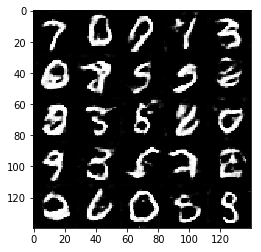

Epoch 1/2... Discriminator Loss: 1.1330... Generator Loss: 1.3595
Epoch 1/2... Discriminator Loss: 1.3059... Generator Loss: 0.7482
Epoch 1/2... Discriminator Loss: 1.3849... Generator Loss: 0.6406
Epoch 1/2... Discriminator Loss: 1.2199... Generator Loss: 1.1486
Epoch 1/2... Discriminator Loss: 1.5841... Generator Loss: 0.5444
Epoch 1/2... Discriminator Loss: 1.3046... Generator Loss: 1.2251
Epoch 1/2... Discriminator Loss: 1.2709... Generator Loss: 1.4241
Epoch 1/2... Discriminator Loss: 1.2148... Generator Loss: 0.9807
Epoch 1/2... Discriminator Loss: 1.1997... Generator Loss: 1.0392
Epoch 1/2... Discriminator Loss: 1.4709... Generator Loss: 0.5952
iteration 900


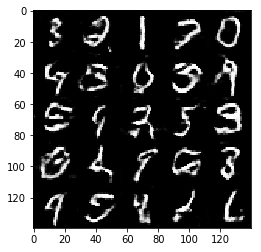

Epoch 1/2... Discriminator Loss: 1.0771... Generator Loss: 1.1816
Epoch 1/2... Discriminator Loss: 1.8943... Generator Loss: 0.3695
Epoch 1/2... Discriminator Loss: 1.5221... Generator Loss: 0.6326
Epoch 1/2... Discriminator Loss: 1.2681... Generator Loss: 1.2507
Epoch 1/2... Discriminator Loss: 1.2686... Generator Loss: 0.8247
Epoch 1/2... Discriminator Loss: 1.3158... Generator Loss: 0.7297
Epoch 1/2... Discriminator Loss: 1.1387... Generator Loss: 1.1656
Epoch 1/2... Discriminator Loss: 1.2113... Generator Loss: 0.7811
Epoch 1/2... Discriminator Loss: 1.1844... Generator Loss: 1.0186
Epoch 1/2... Discriminator Loss: 1.9062... Generator Loss: 2.6997
iteration 1000


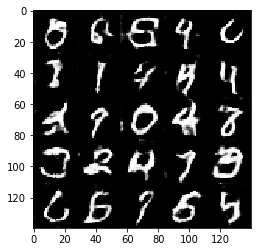

Epoch 1/2... Discriminator Loss: 1.2252... Generator Loss: 1.0030
Epoch 1/2... Discriminator Loss: 1.3126... Generator Loss: 0.7840
Epoch 1/2... Discriminator Loss: 1.0769... Generator Loss: 1.5330
Epoch 1/2... Discriminator Loss: 1.2214... Generator Loss: 1.5986
Epoch 1/2... Discriminator Loss: 1.2399... Generator Loss: 0.8847
Epoch 1/2... Discriminator Loss: 1.1575... Generator Loss: 0.9013
Epoch 1/2... Discriminator Loss: 1.1062... Generator Loss: 1.1004
Epoch 1/2... Discriminator Loss: 1.2262... Generator Loss: 1.0602
Epoch 1/2... Discriminator Loss: 1.1167... Generator Loss: 2.0242
Epoch 1/2... Discriminator Loss: 1.4685... Generator Loss: 0.5538
iteration 1100


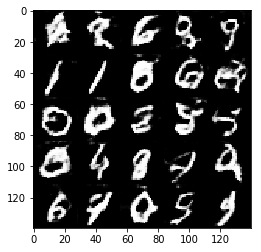

Epoch 1/2... Discriminator Loss: 1.2441... Generator Loss: 0.9336
Epoch 1/2... Discriminator Loss: 1.0732... Generator Loss: 1.2596
Epoch 1/2... Discriminator Loss: 1.1801... Generator Loss: 1.9580
Epoch 1/2... Discriminator Loss: 1.1397... Generator Loss: 0.8596
Epoch 1/2... Discriminator Loss: 1.1878... Generator Loss: 0.9037
Epoch 1/2... Discriminator Loss: 1.0418... Generator Loss: 1.1611
Epoch 1/2... Discriminator Loss: 1.4217... Generator Loss: 0.6610
Epoch 1/2... Discriminator Loss: 1.1803... Generator Loss: 0.9089
Epoch 1/2... Discriminator Loss: 1.3401... Generator Loss: 0.6128
Epoch 1/2... Discriminator Loss: 1.0610... Generator Loss: 1.3776
iteration 1200


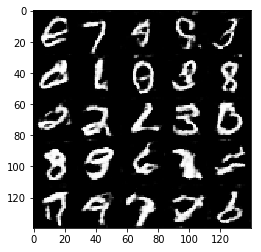

Epoch 1/2... Discriminator Loss: 1.2247... Generator Loss: 1.6660
Epoch 1/2... Discriminator Loss: 1.2175... Generator Loss: 2.2169
Epoch 1/2... Discriminator Loss: 1.1390... Generator Loss: 1.3267
Epoch 1/2... Discriminator Loss: 1.1468... Generator Loss: 2.0234
Epoch 1/2... Discriminator Loss: 1.4795... Generator Loss: 0.6367
Epoch 1/2... Discriminator Loss: 1.4046... Generator Loss: 0.6195
Epoch 1/2... Discriminator Loss: 1.1679... Generator Loss: 0.8963
Epoch 1/2... Discriminator Loss: 1.1166... Generator Loss: 1.2876
Epoch 1/2... Discriminator Loss: 1.1878... Generator Loss: 0.9186
Epoch 1/2... Discriminator Loss: 1.0673... Generator Loss: 1.5641
iteration 1300


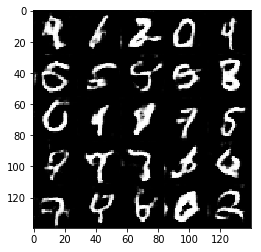

Epoch 1/2... Discriminator Loss: 1.0735... Generator Loss: 1.8757
Epoch 1/2... Discriminator Loss: 1.6231... Generator Loss: 0.5166
Epoch 1/2... Discriminator Loss: 1.1953... Generator Loss: 0.9776
Epoch 1/2... Discriminator Loss: 1.3173... Generator Loss: 0.8048
Epoch 1/2... Discriminator Loss: 1.1256... Generator Loss: 1.4728
Epoch 1/2... Discriminator Loss: 1.1618... Generator Loss: 0.9319
Epoch 1/2... Discriminator Loss: 1.3455... Generator Loss: 0.7277
Epoch 1/2... Discriminator Loss: 1.0121... Generator Loss: 1.6757
Epoch 1/2... Discriminator Loss: 1.1377... Generator Loss: 1.6925
Epoch 1/2... Discriminator Loss: 1.1208... Generator Loss: 1.0884
iteration 1400


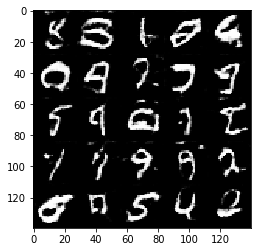

Epoch 1/2... Discriminator Loss: 1.6519... Generator Loss: 0.5300
Epoch 1/2... Discriminator Loss: 1.1743... Generator Loss: 1.2674
Epoch 1/2... Discriminator Loss: 1.1288... Generator Loss: 0.9706
Epoch 1/2... Discriminator Loss: 1.1085... Generator Loss: 1.1926
Epoch 1/2... Discriminator Loss: 1.0833... Generator Loss: 1.1547
Epoch 1/2... Discriminator Loss: 1.3203... Generator Loss: 0.7067
Epoch 1/2... Discriminator Loss: 1.2936... Generator Loss: 2.8444
Epoch 1/2... Discriminator Loss: 1.3676... Generator Loss: 0.8760
Epoch 1/2... Discriminator Loss: 1.0058... Generator Loss: 1.4052
Epoch 1/2... Discriminator Loss: 1.0960... Generator Loss: 1.6669
iteration 1500


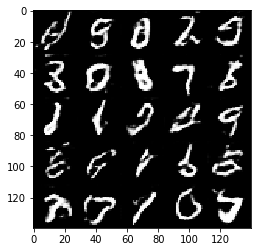

Epoch 1/2... Discriminator Loss: 1.2382... Generator Loss: 0.8039
Epoch 1/2... Discriminator Loss: 1.2916... Generator Loss: 1.3300
Epoch 1/2... Discriminator Loss: 1.2387... Generator Loss: 0.8398
Epoch 1/2... Discriminator Loss: 1.1795... Generator Loss: 1.0264
Epoch 1/2... Discriminator Loss: 1.0999... Generator Loss: 1.1409
Epoch 1/2... Discriminator Loss: 1.2822... Generator Loss: 0.7892
Epoch 1/2... Discriminator Loss: 1.0613... Generator Loss: 1.2402
Epoch 1/2... Discriminator Loss: 1.2629... Generator Loss: 0.7531
Epoch 1/2... Discriminator Loss: 1.1462... Generator Loss: 0.9815
Epoch 1/2... Discriminator Loss: 1.4570... Generator Loss: 0.7360
iteration 1600


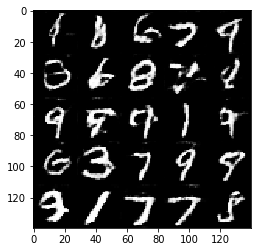

Epoch 1/2... Discriminator Loss: 1.0125... Generator Loss: 1.6118
Epoch 1/2... Discriminator Loss: 1.1855... Generator Loss: 1.3910
Epoch 1/2... Discriminator Loss: 0.9506... Generator Loss: 1.4915
Epoch 1/2... Discriminator Loss: 1.2947... Generator Loss: 0.7711
Epoch 1/2... Discriminator Loss: 1.1232... Generator Loss: 2.2283
Epoch 1/2... Discriminator Loss: 1.1290... Generator Loss: 1.0596
Epoch 1/2... Discriminator Loss: 1.0007... Generator Loss: 1.4044
Epoch 1/2... Discriminator Loss: 0.9459... Generator Loss: 1.3368
Epoch 1/2... Discriminator Loss: 0.9846... Generator Loss: 1.3823
Epoch 1/2... Discriminator Loss: 1.2210... Generator Loss: 0.8924
iteration 1700


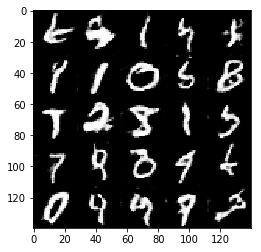

Epoch 1/2... Discriminator Loss: 0.9857... Generator Loss: 1.9535
Epoch 1/2... Discriminator Loss: 1.0017... Generator Loss: 1.5064
Epoch 1/2... Discriminator Loss: 1.0595... Generator Loss: 2.1046
Epoch 1/2... Discriminator Loss: 1.3453... Generator Loss: 0.7237
Epoch 1/2... Discriminator Loss: 1.2745... Generator Loss: 0.7805
Epoch 1/2... Discriminator Loss: 1.3413... Generator Loss: 0.6774
Epoch 1/2... Discriminator Loss: 1.1746... Generator Loss: 1.0977
Epoch 1/2... Discriminator Loss: 1.1487... Generator Loss: 1.0882
Epoch 1/2... Discriminator Loss: 1.7743... Generator Loss: 0.5330
Epoch 1/2... Discriminator Loss: 1.1187... Generator Loss: 1.2997
iteration 1800


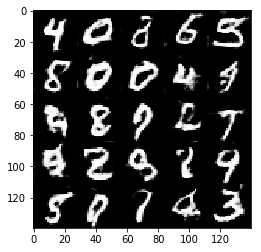

Epoch 1/2... Discriminator Loss: 1.1362... Generator Loss: 2.0892
Epoch 1/2... Discriminator Loss: 1.1229... Generator Loss: 1.0192
Epoch 1/2... Discriminator Loss: 1.4071... Generator Loss: 0.7218
Epoch 1/2... Discriminator Loss: 0.9983... Generator Loss: 1.4976
Epoch 1/2... Discriminator Loss: 0.8960... Generator Loss: 1.5994
Epoch 1/2... Discriminator Loss: 1.0305... Generator Loss: 1.5204
Epoch 1/2... Discriminator Loss: 1.4609... Generator Loss: 0.6602
Epoch 2/2... Discriminator Loss: 1.1929... Generator Loss: 2.2274
Epoch 2/2... Discriminator Loss: 1.2275... Generator Loss: 0.9365
Epoch 2/2... Discriminator Loss: 0.9761... Generator Loss: 1.2968
iteration 1900


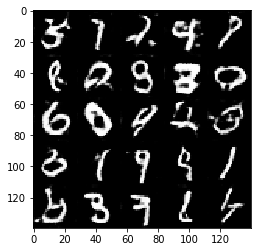

Epoch 2/2... Discriminator Loss: 0.9669... Generator Loss: 1.2176
Epoch 2/2... Discriminator Loss: 0.9272... Generator Loss: 1.8059
Epoch 2/2... Discriminator Loss: 1.5055... Generator Loss: 0.6323
Epoch 2/2... Discriminator Loss: 1.1517... Generator Loss: 1.0803
Epoch 2/2... Discriminator Loss: 1.3671... Generator Loss: 0.7828
Epoch 2/2... Discriminator Loss: 1.0768... Generator Loss: 1.9385
Epoch 2/2... Discriminator Loss: 0.9293... Generator Loss: 1.9216
Epoch 2/2... Discriminator Loss: 1.2189... Generator Loss: 1.0984
Epoch 2/2... Discriminator Loss: 1.0054... Generator Loss: 1.4058
Epoch 2/2... Discriminator Loss: 1.3098... Generator Loss: 0.8381
iteration 2000


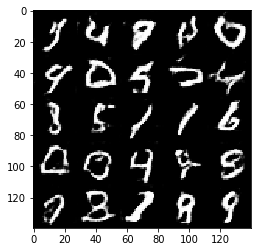

Epoch 2/2... Discriminator Loss: 1.2952... Generator Loss: 0.7372
Epoch 2/2... Discriminator Loss: 1.2602... Generator Loss: 0.9066
Epoch 2/2... Discriminator Loss: 0.9516... Generator Loss: 1.3824
Epoch 2/2... Discriminator Loss: 1.1305... Generator Loss: 1.1172
Epoch 2/2... Discriminator Loss: 1.2694... Generator Loss: 2.7039
Epoch 2/2... Discriminator Loss: 0.9012... Generator Loss: 1.9279
Epoch 2/2... Discriminator Loss: 0.9368... Generator Loss: 1.7161
Epoch 2/2... Discriminator Loss: 1.1373... Generator Loss: 0.9838
Epoch 2/2... Discriminator Loss: 1.1745... Generator Loss: 2.2196
Epoch 2/2... Discriminator Loss: 1.3708... Generator Loss: 0.7697
iteration 2100


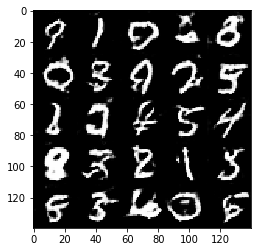

Epoch 2/2... Discriminator Loss: 1.3973... Generator Loss: 2.7032
Epoch 2/2... Discriminator Loss: 1.5412... Generator Loss: 0.6585
Epoch 2/2... Discriminator Loss: 0.8573... Generator Loss: 1.8729
Epoch 2/2... Discriminator Loss: 0.9920... Generator Loss: 1.9591
Epoch 2/2... Discriminator Loss: 1.0041... Generator Loss: 2.0292
Epoch 2/2... Discriminator Loss: 2.0405... Generator Loss: 0.3169
Epoch 2/2... Discriminator Loss: 1.0439... Generator Loss: 1.3724
Epoch 2/2... Discriminator Loss: 1.0519... Generator Loss: 1.6906
Epoch 2/2... Discriminator Loss: 1.4446... Generator Loss: 0.7124
Epoch 2/2... Discriminator Loss: 1.1831... Generator Loss: 2.2386
iteration 2200


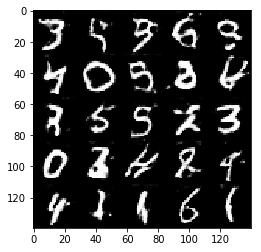

Epoch 2/2... Discriminator Loss: 1.1383... Generator Loss: 2.6541
Epoch 2/2... Discriminator Loss: 1.5234... Generator Loss: 0.6883
Epoch 2/2... Discriminator Loss: 0.9295... Generator Loss: 1.9004
Epoch 2/2... Discriminator Loss: 0.9564... Generator Loss: 1.6504
Epoch 2/2... Discriminator Loss: 0.9433... Generator Loss: 1.5676
Epoch 2/2... Discriminator Loss: 0.8771... Generator Loss: 1.7568
Epoch 2/2... Discriminator Loss: 0.9043... Generator Loss: 1.4398
Epoch 2/2... Discriminator Loss: 1.0362... Generator Loss: 1.2450
Epoch 2/2... Discriminator Loss: 1.0100... Generator Loss: 1.4019
Epoch 2/2... Discriminator Loss: 0.9269... Generator Loss: 1.8235
iteration 2300


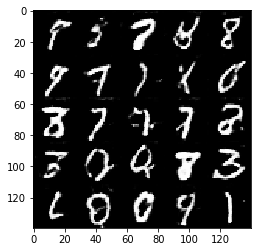

Epoch 2/2... Discriminator Loss: 0.9977... Generator Loss: 1.3480
Epoch 2/2... Discriminator Loss: 0.9241... Generator Loss: 1.6032
Epoch 2/2... Discriminator Loss: 1.0152... Generator Loss: 1.1672
Epoch 2/2... Discriminator Loss: 0.8371... Generator Loss: 2.3237
Epoch 2/2... Discriminator Loss: 1.0348... Generator Loss: 2.5922
Epoch 2/2... Discriminator Loss: 0.8136... Generator Loss: 2.7510
Epoch 2/2... Discriminator Loss: 1.0165... Generator Loss: 1.5663
Epoch 2/2... Discriminator Loss: 2.2520... Generator Loss: 0.3983
Epoch 2/2... Discriminator Loss: 1.2993... Generator Loss: 2.1190
Epoch 2/2... Discriminator Loss: 1.2371... Generator Loss: 0.9284
iteration 2400


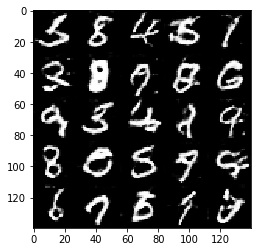

Epoch 2/2... Discriminator Loss: 1.1993... Generator Loss: 0.9474
Epoch 2/2... Discriminator Loss: 0.9777... Generator Loss: 1.2832
Epoch 2/2... Discriminator Loss: 1.4209... Generator Loss: 2.7157
Epoch 2/2... Discriminator Loss: 1.0470... Generator Loss: 1.0807
Epoch 2/2... Discriminator Loss: 0.9616... Generator Loss: 1.7020
Epoch 2/2... Discriminator Loss: 1.1879... Generator Loss: 1.1845
Epoch 2/2... Discriminator Loss: 1.2130... Generator Loss: 1.0411
Epoch 2/2... Discriminator Loss: 0.9964... Generator Loss: 1.2565
Epoch 2/2... Discriminator Loss: 1.2556... Generator Loss: 0.8528
Epoch 2/2... Discriminator Loss: 0.8960... Generator Loss: 1.4858
iteration 2500


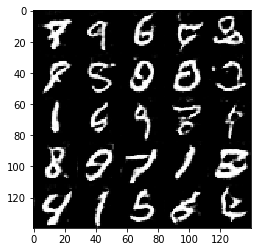

Epoch 2/2... Discriminator Loss: 0.8561... Generator Loss: 2.3957
Epoch 2/2... Discriminator Loss: 1.5526... Generator Loss: 0.7244
Epoch 2/2... Discriminator Loss: 0.9823... Generator Loss: 1.1899
Epoch 2/2... Discriminator Loss: 1.1855... Generator Loss: 0.9437
Epoch 2/2... Discriminator Loss: 1.0031... Generator Loss: 2.0522
Epoch 2/2... Discriminator Loss: 0.8774... Generator Loss: 2.0511
Epoch 2/2... Discriminator Loss: 0.7999... Generator Loss: 2.0968
Epoch 2/2... Discriminator Loss: 0.8986... Generator Loss: 1.7964
Epoch 2/2... Discriminator Loss: 1.7007... Generator Loss: 0.6082
Epoch 2/2... Discriminator Loss: 0.9967... Generator Loss: 1.3835
iteration 2600


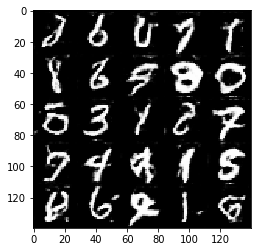

Epoch 2/2... Discriminator Loss: 0.8701... Generator Loss: 1.6606
Epoch 2/2... Discriminator Loss: 0.8314... Generator Loss: 1.9271
Epoch 2/2... Discriminator Loss: 0.9998... Generator Loss: 1.3098
Epoch 2/2... Discriminator Loss: 0.9850... Generator Loss: 2.2604
Epoch 2/2... Discriminator Loss: 1.2820... Generator Loss: 0.9221
Epoch 2/2... Discriminator Loss: 0.8310... Generator Loss: 1.7091
Epoch 2/2... Discriminator Loss: 0.9820... Generator Loss: 1.1714
Epoch 2/2... Discriminator Loss: 0.8777... Generator Loss: 1.8200
Epoch 2/2... Discriminator Loss: 0.9346... Generator Loss: 1.9794
Epoch 2/2... Discriminator Loss: 1.2225... Generator Loss: 0.9891
iteration 2700


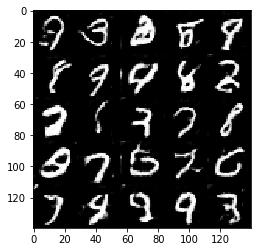

Epoch 2/2... Discriminator Loss: 0.8262... Generator Loss: 1.9013
Epoch 2/2... Discriminator Loss: 1.0348... Generator Loss: 1.4471
Epoch 2/2... Discriminator Loss: 0.8869... Generator Loss: 2.6258
Epoch 2/2... Discriminator Loss: 1.0053... Generator Loss: 1.4337
Epoch 2/2... Discriminator Loss: 0.8652... Generator Loss: 1.7205
Epoch 2/2... Discriminator Loss: 0.9642... Generator Loss: 1.7491
Epoch 2/2... Discriminator Loss: 1.0880... Generator Loss: 2.5128
Epoch 2/2... Discriminator Loss: 0.8493... Generator Loss: 1.4824
Epoch 2/2... Discriminator Loss: 1.2486... Generator Loss: 1.0265
Epoch 2/2... Discriminator Loss: 1.2701... Generator Loss: 1.0620
iteration 2800


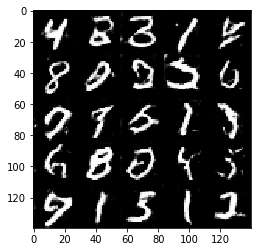

Epoch 2/2... Discriminator Loss: 1.0009... Generator Loss: 1.2248
Epoch 2/2... Discriminator Loss: 0.8101... Generator Loss: 2.6163
Epoch 2/2... Discriminator Loss: 0.9253... Generator Loss: 1.7483
Epoch 2/2... Discriminator Loss: 0.9243... Generator Loss: 2.6721
Epoch 2/2... Discriminator Loss: 0.8991... Generator Loss: 1.8548
Epoch 2/2... Discriminator Loss: 1.7298... Generator Loss: 0.4967
Epoch 2/2... Discriminator Loss: 0.8372... Generator Loss: 1.6038
Epoch 2/2... Discriminator Loss: 0.9552... Generator Loss: 2.0102
Epoch 2/2... Discriminator Loss: 0.9174... Generator Loss: 2.3547
Epoch 2/2... Discriminator Loss: 0.8336... Generator Loss: 1.6277
iteration 2900


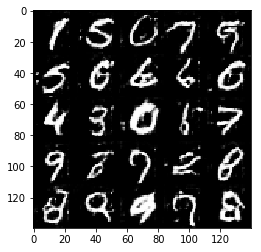

Epoch 2/2... Discriminator Loss: 0.8453... Generator Loss: 2.2277
Epoch 2/2... Discriminator Loss: 0.9383... Generator Loss: 1.6576
Epoch 2/2... Discriminator Loss: 1.2868... Generator Loss: 0.8707
Epoch 2/2... Discriminator Loss: 1.2760... Generator Loss: 0.8723
Epoch 2/2... Discriminator Loss: 0.9996... Generator Loss: 1.4207
Epoch 2/2... Discriminator Loss: 0.9440... Generator Loss: 1.3548
Epoch 2/2... Discriminator Loss: 1.0879... Generator Loss: 1.1960
Epoch 2/2... Discriminator Loss: 0.8812... Generator Loss: 1.7560
Epoch 2/2... Discriminator Loss: 1.1082... Generator Loss: 1.1970
Epoch 2/2... Discriminator Loss: 1.3284... Generator Loss: 2.4608
iteration 3000


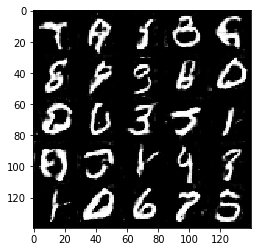

Epoch 2/2... Discriminator Loss: 0.9557... Generator Loss: 1.7527
Epoch 2/2... Discriminator Loss: 1.0399... Generator Loss: 1.2468
Epoch 2/2... Discriminator Loss: 1.0647... Generator Loss: 1.3768
Epoch 2/2... Discriminator Loss: 1.1277... Generator Loss: 1.2043
Epoch 2/2... Discriminator Loss: 1.2202... Generator Loss: 0.9318
Epoch 2/2... Discriminator Loss: 1.2179... Generator Loss: 0.9797
Epoch 2/2... Discriminator Loss: 1.0331... Generator Loss: 1.2952
Epoch 2/2... Discriminator Loss: 0.9877... Generator Loss: 2.0913
Epoch 2/2... Discriminator Loss: 1.0753... Generator Loss: 1.2566
Epoch 2/2... Discriminator Loss: 0.9351... Generator Loss: 1.4102
iteration 3100


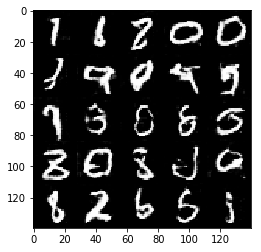

Epoch 2/2... Discriminator Loss: 0.9377... Generator Loss: 2.5125
Epoch 2/2... Discriminator Loss: 0.9140... Generator Loss: 1.6420
Epoch 2/2... Discriminator Loss: 0.8092... Generator Loss: 1.9723
Epoch 2/2... Discriminator Loss: 0.9859... Generator Loss: 2.3347
Epoch 2/2... Discriminator Loss: 1.0410... Generator Loss: 2.9419
Epoch 2/2... Discriminator Loss: 1.0243... Generator Loss: 1.3846
Epoch 2/2... Discriminator Loss: 0.9037... Generator Loss: 2.0181
Epoch 2/2... Discriminator Loss: 0.9795... Generator Loss: 1.8288
Epoch 2/2... Discriminator Loss: 0.8667... Generator Loss: 1.8149
Epoch 2/2... Discriminator Loss: 1.0828... Generator Loss: 2.0177
iteration 3200


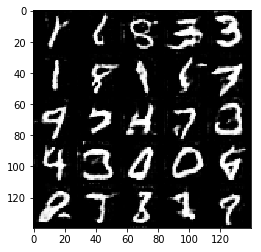

Epoch 2/2... Discriminator Loss: 0.8800... Generator Loss: 1.6070
Epoch 2/2... Discriminator Loss: 1.2752... Generator Loss: 1.0289
Epoch 2/2... Discriminator Loss: 0.9957... Generator Loss: 2.3575
Epoch 2/2... Discriminator Loss: 1.1937... Generator Loss: 0.9506
Epoch 2/2... Discriminator Loss: 0.9387... Generator Loss: 1.6247
Epoch 2/2... Discriminator Loss: 0.9291... Generator Loss: 1.5186
Epoch 2/2... Discriminator Loss: 1.4148... Generator Loss: 0.8357
Epoch 2/2... Discriminator Loss: 1.0496... Generator Loss: 1.5395
Epoch 2/2... Discriminator Loss: 1.0268... Generator Loss: 2.0118
Epoch 2/2... Discriminator Loss: 1.1296... Generator Loss: 2.5433
iteration 3300


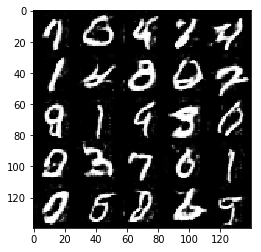

Epoch 2/2... Discriminator Loss: 0.8613... Generator Loss: 2.0048
Epoch 2/2... Discriminator Loss: 1.0089... Generator Loss: 1.2838
Epoch 2/2... Discriminator Loss: 0.9375... Generator Loss: 1.2965
Epoch 2/2... Discriminator Loss: 0.8264... Generator Loss: 1.9757
Epoch 2/2... Discriminator Loss: 0.8717... Generator Loss: 1.7270
Epoch 2/2... Discriminator Loss: 0.8252... Generator Loss: 1.9968
Epoch 2/2... Discriminator Loss: 1.1264... Generator Loss: 1.0307
Epoch 2/2... Discriminator Loss: 1.0641... Generator Loss: 2.5338
Epoch 2/2... Discriminator Loss: 1.0750... Generator Loss: 2.4025
Epoch 2/2... Discriminator Loss: 0.7980... Generator Loss: 2.5412
iteration 3400


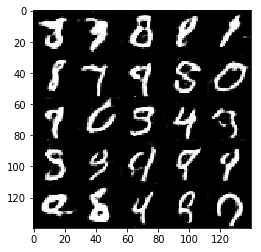

Epoch 2/2... Discriminator Loss: 1.2897... Generator Loss: 2.8835
Epoch 2/2... Discriminator Loss: 1.0524... Generator Loss: 1.3102
Epoch 2/2... Discriminator Loss: 0.9892... Generator Loss: 1.1739
Epoch 2/2... Discriminator Loss: 1.0116... Generator Loss: 1.4693
Epoch 2/2... Discriminator Loss: 1.1814... Generator Loss: 3.0794
Epoch 2/2... Discriminator Loss: 0.7896... Generator Loss: 2.4411
Epoch 2/2... Discriminator Loss: 1.2628... Generator Loss: 0.9268
Epoch 2/2... Discriminator Loss: 0.9892... Generator Loss: 1.4926
Epoch 2/2... Discriminator Loss: 0.8769... Generator Loss: 1.8989
Epoch 2/2... Discriminator Loss: 1.0397... Generator Loss: 2.3488
iteration 3500


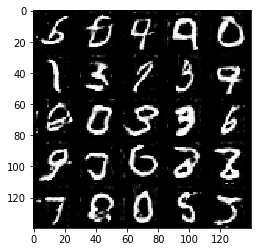

Epoch 2/2... Discriminator Loss: 0.9293... Generator Loss: 1.4198
Epoch 2/2... Discriminator Loss: 0.9336... Generator Loss: 1.7748
Epoch 2/2... Discriminator Loss: 1.0183... Generator Loss: 1.3317
Epoch 2/2... Discriminator Loss: 0.8886... Generator Loss: 1.4983
Epoch 2/2... Discriminator Loss: 1.1759... Generator Loss: 1.3565
Epoch 2/2... Discriminator Loss: 1.3321... Generator Loss: 0.8363
Epoch 2/2... Discriminator Loss: 0.8124... Generator Loss: 2.8545
Epoch 2/2... Discriminator Loss: 0.9929... Generator Loss: 1.3874
Epoch 2/2... Discriminator Loss: 0.8458... Generator Loss: 1.8959
Epoch 2/2... Discriminator Loss: 0.9090... Generator Loss: 1.5175
iteration 3600


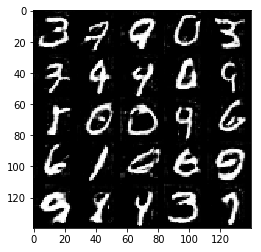

Epoch 2/2... Discriminator Loss: 0.8702... Generator Loss: 2.0210
Epoch 2/2... Discriminator Loss: 0.9339... Generator Loss: 1.7178
Epoch 2/2... Discriminator Loss: 0.9297... Generator Loss: 2.2292
Epoch 2/2... Discriminator Loss: 1.0480... Generator Loss: 2.7482
Epoch 2/2... Discriminator Loss: 1.4816... Generator Loss: 3.2226
Epoch 2/2... Discriminator Loss: 0.8858... Generator Loss: 2.1809
Epoch 2/2... Discriminator Loss: 0.8320... Generator Loss: 1.7016
Epoch 2/2... Discriminator Loss: 0.7992... Generator Loss: 2.2374
Epoch 2/2... Discriminator Loss: 0.7948... Generator Loss: 2.2353
Epoch 2/2... Discriminator Loss: 0.8002... Generator Loss: 2.1140
iteration 3700


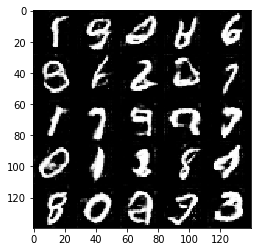

Epoch 2/2... Discriminator Loss: 1.4820... Generator Loss: 0.8197
Epoch 2/2... Discriminator Loss: 0.8390... Generator Loss: 2.1274
Epoch 2/2... Discriminator Loss: 0.8360... Generator Loss: 1.8569
Epoch 2/2... Discriminator Loss: 2.4661... Generator Loss: 4.8343
Epoch 2/2... Discriminator Loss: 0.9910... Generator Loss: 1.3518
iteration 3750


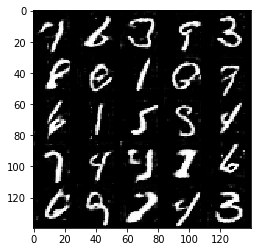

Training done seconds: 272.35957288742065. Time in minutes: 4.539326214790345. Iterations: 3750


In [282]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.3
print('Starting...')


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Starting...
Epoch 1/1... Discriminator Loss: 1.7341... Generator Loss: 1.1498
Epoch 1/1... Discriminator Loss: 1.6730... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 2.4817... Generator Loss: 2.6511
Epoch 1/1... Discriminator Loss: 1.5485... Generator Loss: 2.0057
Epoch 1/1... Discriminator Loss: 1.5510... Generator Loss: 0.4503
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.5316
Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 2.0711
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 2.3145
iteration 100


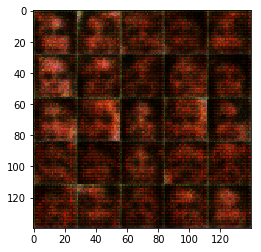

Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 1.9319
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 1.8255
Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 1.1332
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.5093
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 1.5046... Generator Loss: 1.6260
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 1.2658
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.6015
iteration 200


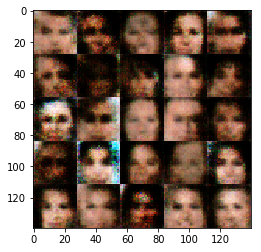

Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 1.1499
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.5236
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 1.3452
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 1.0461
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.5456... Generator Loss: 0.4250
iteration 300


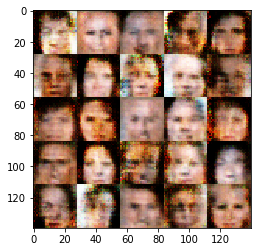

Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 1.1598
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.8480
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.5081
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.9778
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.6452
iteration 400


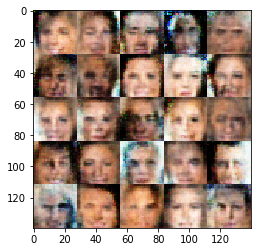

Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.8912
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.5648... Generator Loss: 0.9563
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 1.1317
Epoch 1/1... Discriminator Loss: 1.6107... Generator Loss: 0.3715
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.5746... Generator Loss: 0.3851
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.8181
iteration 500


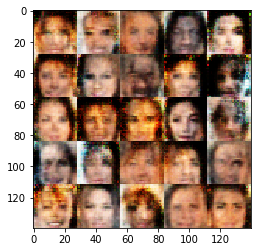

Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.5590... Generator Loss: 1.4748
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.5603
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.5822
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.5300... Generator Loss: 1.3094
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.9027
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.9168
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 1.0522
iteration 600


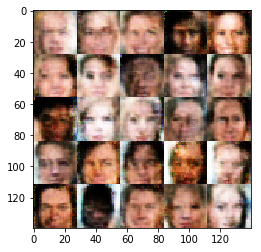

Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.5966... Generator Loss: 0.3875
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.9008
Epoch 1/1... Discriminator Loss: 1.5149... Generator Loss: 0.3782
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.9653
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 1.2194
Epoch 1/1... Discriminator Loss: 1.4854... Generator Loss: 0.9185
iteration 700


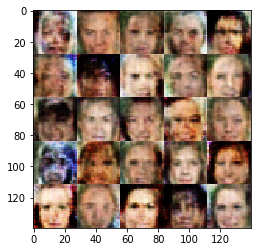

Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 0.5083
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.9454
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.4880
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.6556
iteration 800


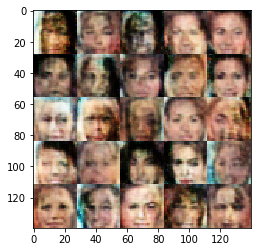

Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.4222
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.4562
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.8402
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.5127
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.7651
iteration 900


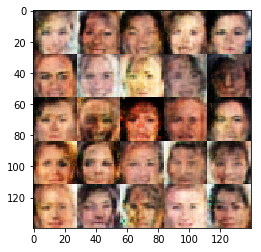

Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.5445
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.5984
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.7729
iteration 1000


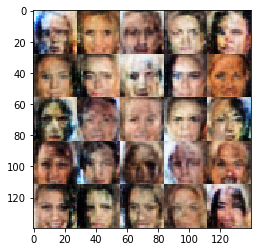

Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.5517
Epoch 1/1... Discriminator Loss: 1.5377... Generator Loss: 0.5444
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.4646
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.7920
iteration 1100


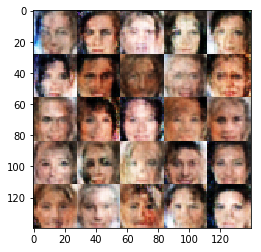

Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.5893
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.5479
iteration 1200


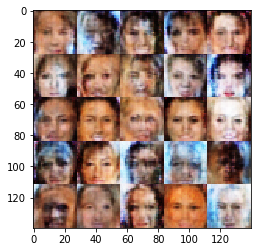

Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 1.0172
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.5219... Generator Loss: 0.4562
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.5337
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.9814
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.6811
iteration 1300


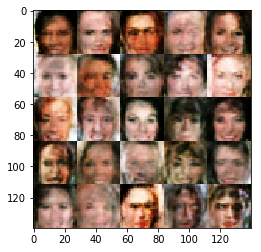

Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.5724
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7701
iteration 1400


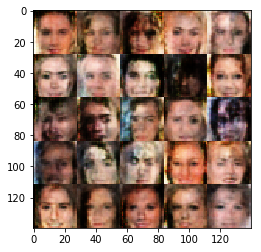

Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.6134
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.8357
iteration 1500


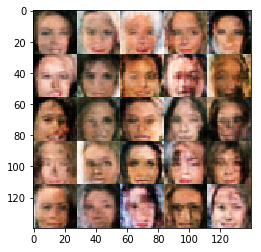

Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.5327
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.9694
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.6423
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.8369
iteration 1600


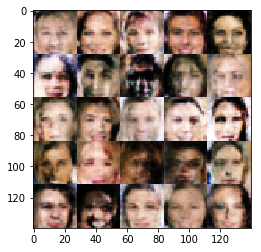

Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.6780
iteration 1700


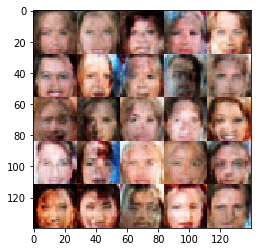

Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.6074
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.5795
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.4451
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.6174
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 1.0800
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.7456
iteration 1800


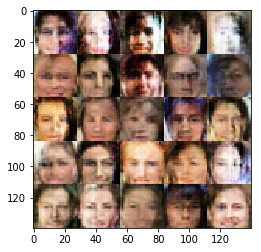

Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.5942
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.6815
iteration 1900


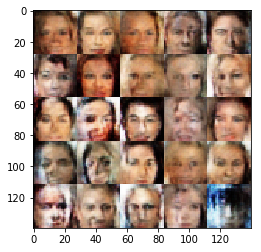

Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.5685
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.5187
iteration 2000


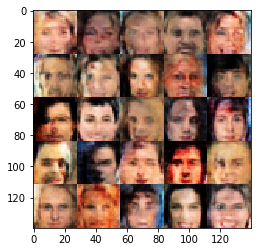

Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.5636
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.6191
iteration 2100


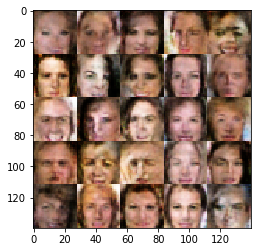

Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.6005
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.5420
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.5373
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.7116
iteration 2200


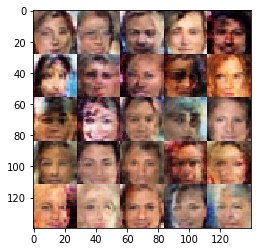

Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.5951
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.6367
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.6050
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.6667
iteration 2300


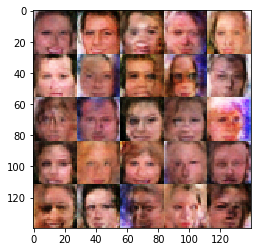

Epoch 1/1... Discriminator Loss: 1.5647... Generator Loss: 0.4401
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.5227
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.5973
iteration 2400


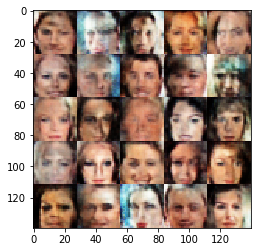

Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.6083
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.8818
iteration 2500


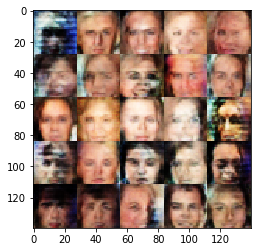

Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.5720
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.5912
iteration 2600


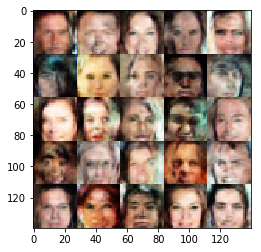

Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.4823
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.8640
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.9599
iteration 2700


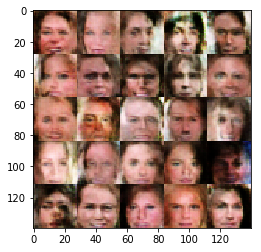

Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.9793
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.8502
iteration 2800


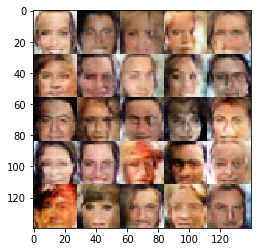

Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.4581
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.6056
iteration 2900


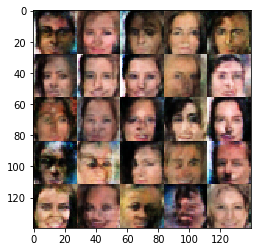

Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.5390
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.7799
iteration 3000


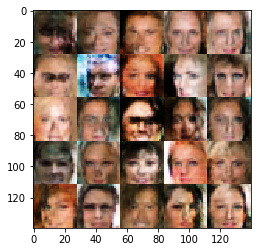

Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 1.1450
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.5926
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7395
iteration 3100


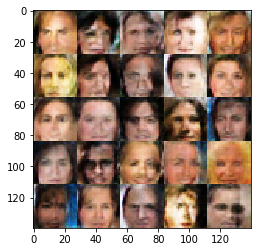

Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.5176
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.5768
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.6244
iteration 3200


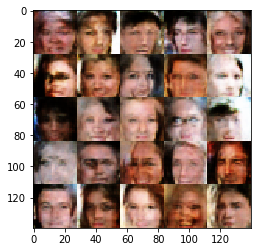

Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 1.0077
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.5380
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.6568
iteration 3300


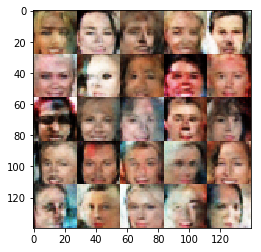

Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.7345
iteration 3400


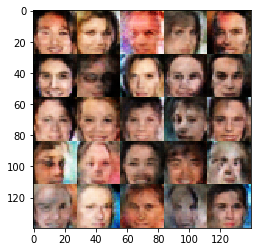

Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.5592
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.5875
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.6797
iteration 3500


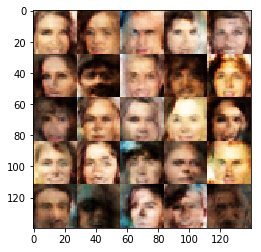

Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.5716
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.6448
iteration 3600


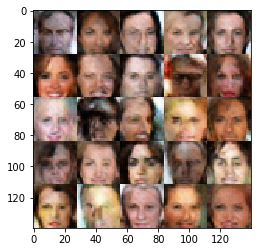

Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.4249
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.8914
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.5870
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.8778
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7420
iteration 3700


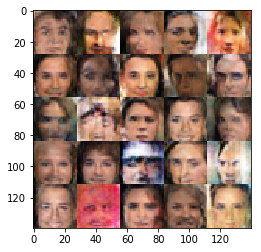

Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.5056... Generator Loss: 0.5335
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.6707
iteration 3750


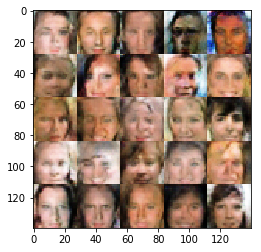

Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.5240
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.5984
iteration 3800


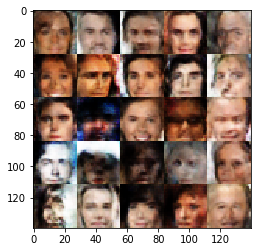

Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.4925
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.6018
iteration 3900


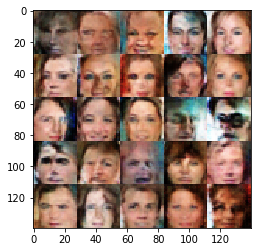

Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.5132
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.5992
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.5951
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.7106
iteration 4000


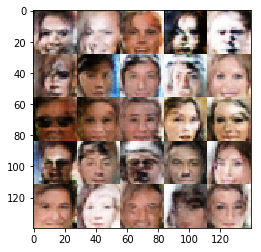

Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.7538
iteration 4100


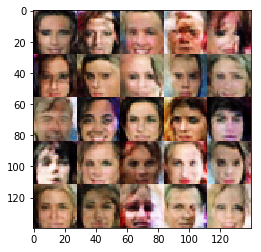

Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.5478
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.5960
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.6038
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.6567
iteration 4200


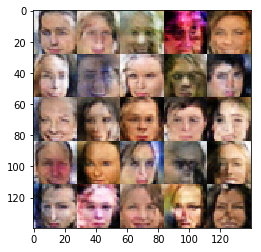

Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.8921
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.6642
iteration 4300


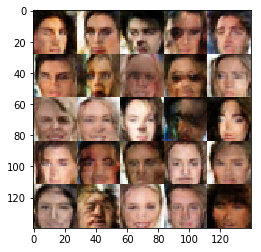

Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.5046
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.5329
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.7662
iteration 4400


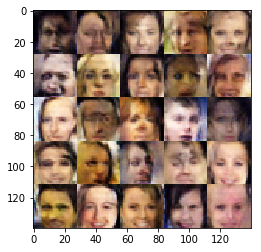

Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.5783
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.5868
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.6498
iteration 4500


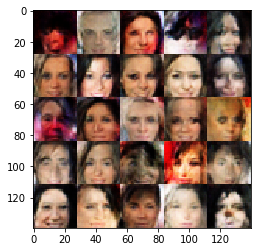

Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.6235
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.5761
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.4894
iteration 4600


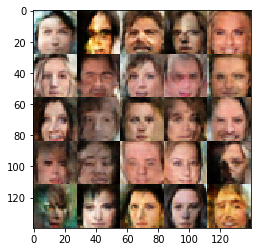

Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.5753
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.5667
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.8994
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.6004
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.7053
iteration 4700


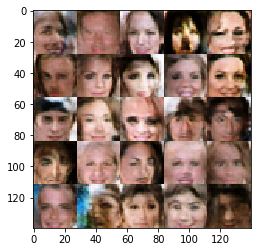

Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.5905
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 1.0185
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.6514
iteration 4800


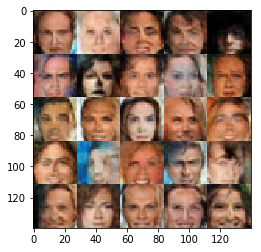

Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.6121
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.8480
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.5300
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.5676
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.6913
iteration 4900


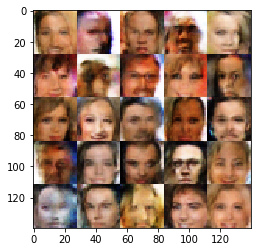

Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.5848
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.5464
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.5908
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.6311
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.5788
iteration 5000


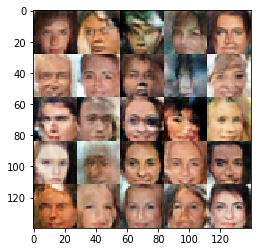

Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.5864
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.5122
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.6042
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.6246
iteration 5100


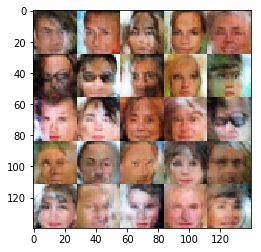

Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.5989
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.6099
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.5991
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.6956
iteration 5200


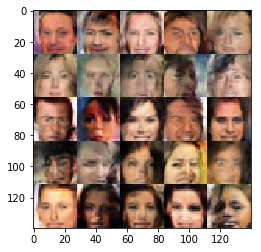

Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.5167
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.4787
iteration 5300


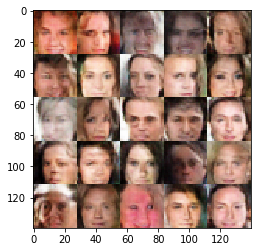

Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.5667
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.5482
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.5989
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.5364
iteration 5400


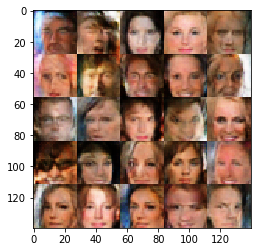

Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.5418
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.5828
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.5624
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.6355
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.8259
iteration 5500


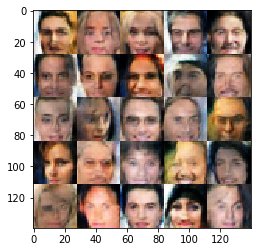

Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.4976
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.5744
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.5882
iteration 5600


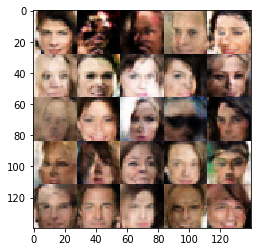

Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.5415
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.5670
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.4785
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.7127
iteration 5700


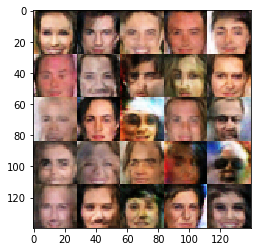

Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 0.5538
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.9363
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.5838
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.6595
iteration 5800


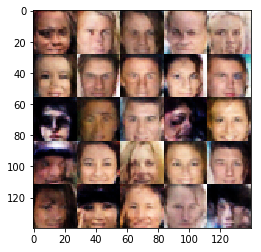

Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.4972
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.6235
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.5781
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.8049
iteration 5900


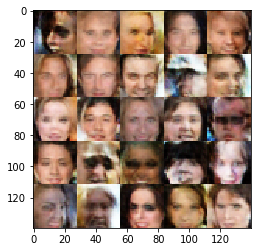

Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.5460
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.5845
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.5420
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.7273
iteration 6000


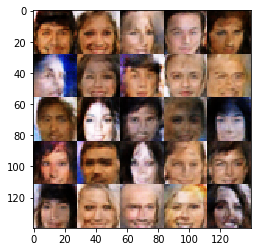

Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.6517
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.8029
iteration 6100


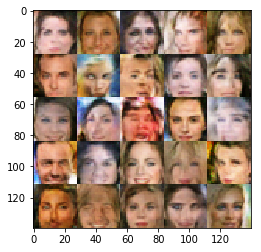

Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.5692
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.6004
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.7403
iteration 6200


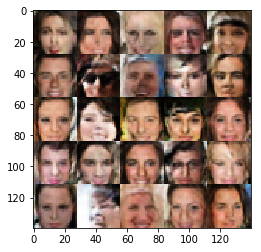

Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.4462
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.5527
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.8059


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.3
print('Starting...')


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.